In [70]:
from model import build_pred_logits, GaussMix, BetaMix, norm_to_ab, norm_to_logdirichlet, get_L_bridge_dirichlet
import jax
from jax import vmap, random
from jax import numpy as jnp


N = 5 #components
D = 1  # output dimension

input_size=3
output_size = N * 3   

alpha_quant=0.


def sample_prior_params_conditional_net(key, M, init_fn):
    v_initfn = vmap(init_fn,(0,None)) 
    sample_keys = jax.random.split(key,M)
    _, res = v_initfn(sample_keys,(-1, input_size))
    return res


def pred_gaussmix(params, x, return_probits, pred_logits):  
    logits = pred_logits(params,x)

    logweights = jax.nn.log_softmax(logits[:N])
    mus = logits[N:(N+N*D)]
    covs = jax.nn.softplus(logits[(N+N*D):])  ## diagonal cov matrix

    mus = mus.reshape(N,D)
    covs = covs.reshape(N,D)

    if return_probits:
        return GaussMix(logweights=logweights, mus=mus, covs=covs), logits 
    else:
        return GaussMix(logweights=logweights, mus=mus, covs=covs)

def logDensGaussMix(y, dist):

    # one or more y, one weighted gaussian dist
    def weightedNormLogPdf(y,dist):
        return jax.scipy.stats.multivariate_normal.logpdf(jnp.expand_dims(y,0), dist.mus, jnp.diag(dist.covs)) + dist.logweights     

    # vmap over gauss components
    vWeightedNormLogPdf = vmap(weightedNormLogPdf, (None,0))

    logdens = vWeightedNormLogPdf(y,dist)
    logdens = jnp.squeeze(logdens)
    logdens = jax.scipy.special.logsumexp(logdens, axis=0)

    return logdens



def pred_betamix(params, x, return_probits, N, scale_ab, L, L1,pred_logits):  #location=0, scale=1., 
    ## NORMALIZATION
    logits = pred_logits(params,x)

    ## SPLITTING
    size_s = N
    logits_s = logits[:(size_s)]

    if L1 is not None: #sorted locations
        size_l = N+1
    else:
        size_l = N
    

    logits_l = logits[(size_s):(size_s+size_l)]


    a,b = norm_to_ab(logits_s, scale_ab, logits_l, alpha_quant, L1)

    size_w = N
    logits_weight = logits[(size_s+size_l):(size_s+size_l+size_w)]

    logweights = norm_to_logdirichlet(logits_weight, L)

    if return_probits:
        return BetaMix(logweights=logweights, alphas=a, betas=b, corr=None), logits 
    else:
        return BetaMix(logweights=logweights, alphas=a, betas=b, corr=None) #, logits_before, logits


# density of y given by the beta mixture dist
# for one beta mixture, one y
def logDensBetaMix(y, dist):


    # one or more y, one weighted beta dist
    def weightedBetaLogPdf(y,dist):
        return jax.scipy.stats.beta.logpdf(y, dist.alphas, dist.betas) + dist.logweights     

    # vmap over beta dists
    vWeightedBetasLogPdf = vmap(weightedBetaLogPdf, (None,0))

    logdens = vWeightedBetasLogPdf(y,dist)
    logdens = jax.scipy.special.logsumexp(logdens,axis=0)

    return logdens





In [ ]:
from functools import partial
from einops import rearrange, reduce, repeat

def loglikelihood(params,x,y, pred,logdens):
    dist = pred(params, x)
    return logdens(y,dist)

## one mixture
def sample_from_gaussmix(rng_key,dist,M_y):
    cat_key, norm_key, rng_key = jax.random.split(rng_key,3)

    c = jax.random.categorical(cat_key, dist.logweights, shape = (M_y,)) 

    mus = jnp.take(dist.mus,c, axis=0)
    covs = jnp.take(dist.covs,c,axis=0)

    covs = (vmap(jnp.diag))(covs)

    ys = jax.random.multivariate_normal(norm_key,mus,covs) 
    return ys

## one mixture
def sample_from_betamix(rng_key,dist,M_y):
    cat_key, beta_key, rng_key = jax.random.split(rng_key,3)
    c = jax.random.categorical(cat_key, dist.logweights, shape = (M_y,)) 

    alphas = jnp.take(dist.alphas,c, axis=0)
    betas = jnp.take(dist.betas,c,axis=0)
 
    ys = jax.random.beta(beta_key,alphas,betas) 
    return ys

def avg_entropy_and_fisher(pred, W,X,rng_key, M_y, sample_fun, logdens_fun):

    dists = vmap(vmap(pred,(0,None)),(None,0))(W,X)

    #sample from each gaussmix

    sample_key, rng_key = jax.random.split(rng_key,2)

    ys = vmap(vmap(sample_fun, (None,0,None)), (None,0, None))(sample_key,dists,M_y)


    # vmap over X,W 
    v_logdens = vmap(vmap(logdens_fun))

    res = v_logdens(ys,dists)


    # average over X,W and y to get avg entropy
    avg_ent = -jnp.mean(res)

    loglik = partial(loglikelihood, pred=pred, logdens=logdens_fun)

    loglikgrad = jax.grad(loglik,argnums=1)

    # map over M_y, them on X and w dimensions 
    v_loglikgrad = vmap(vmap(vmap(loglikgrad,(None,None,0)), (0,None,0)), (None,0,0)) 

    llgrad = v_loglikgrad(W,X,ys)

    #jnp.outer(llgrad,llgrad)
    v_outer = vmap(vmap(vmap(jnp.outer)))
    FIM = v_outer(llgrad,llgrad)
    # take expectation wrt y
    FIM = jnp.mean(FIM, axis=2)

    s, logdet_FIM = jnp.linalg.slogdet(FIM)

    ## filter out negative cases : put 0 in negative cases
    det_fim = jnp.exp(logdet_FIM) * (s>=0)
    sqrt_det_fim = jnp.sqrt(det_fim)

    #print("valid cases: ", jnp.sum(s>=0))

    # average only on valid cases
    avg_sqrt_det_fim = jnp.sum(sqrt_det_fim)/ jnp.sum(s>=0)

    return avg_ent, avg_sqrt_det_fim



In [75]:
16*4*4


256

In [85]:
from functools import partial


seed = 12345
# define the inital state
rng_key = random.PRNGKey(seed)


#sampling repeats for weights
M = 200


#sample normal(0,1) X
batch_size = 50

x_key, w_key, rng_key = jax.random.split(rng_key,3)

X = jax.random.normal(x_key,(batch_size,input_size))

# key for y generation
ent_key, rng_key = jax.random.split(rng_key,2)

STAX=True
parameterization="standard"

nodes = 128
hidden_layers = 1


M_y = 200

activations = ["relu","rbf"] #"erf",
#sigmas = [1.,10.,100.,1000.,10000.]
sigmas = [1.,2.,4.,8.,16.,32.]
prior_scales = [1.,10.,100.,1000.,10000.]

res = []

for activation in activations:
    for sigma in sigmas:
        for prior_scale_ab in prior_scales:

            pred_logits, init_fn, init_fns, get_output_from_last_hidden = build_pred_logits(activation, sigma, nodes, hidden_layers, output_size, input_size, STAX, parameterization, with_scaling=False)

            #sample weights # always same key , only sigma is changing
            W = sample_prior_params_conditional_net(w_key,M, init_fn)

            if prior_scale_ab == prior_scales[0]: # just do it once for GMDN
                predg = jax.jit(partial(pred_gaussmix,return_probits=False, pred_logits=pred_logits))
                gauss_ent, gauss_fisher = avg_entropy_and_fisher(predg, W,X,ent_key, M_y, sample_from_gaussmix, logDensGaussMix)
                #gaussmix["activation"]["entropy"].append(gauss_ent)
                #gaussmix["activation"]["fisher"].append(gauss_fisher)
                #gaussmix["activation"]["sigma"].append(sigma)
                print("GMDN",activation,sigma," ",gauss_ent, gauss_fisher, sep=",")
                res.append({'method': "GMDN", 'activation': activation, 'sigma': sigma, 'inv_lambda': "", "entropy":float(gauss_ent), "Fisher": float(gauss_fisher)})

            pred_logits, init_fn, init_fns, get_output_from_last_hidden = build_pred_logits(activation, sigma, nodes, hidden_layers, output_size, input_size, STAX, parameterization, with_scaling=True)

            prior_alpha_weights = 1.
            L = get_L_bridge_dirichlet(N, prior_alpha_weights)
            predb = jax.jit(partial(pred_betamix, return_probits=False, N = N, scale_ab=prior_scale_ab, L=L, L1=None, pred_logits=pred_logits)) #scale=None, location=None, 

            beta_ent, beta_fisher = avg_entropy_and_fisher(predb, W,X,ent_key, M_y, sample_from_betamix, logDensBetaMix)
            print("BMDN",activation,sigma,prior_scale_ab,beta_ent, beta_fisher, sep=",")
            res.append({'method': "BMDN", 'activation': activation, 'sigma': sigma, 'inv_lambda': prior_scale_ab, "entropy":float(beta_ent), "Fisher": float(beta_fisher)})






GMDN,relu,1.0, ,1.58003364795418,0.07239629035911353
BMDN,relu,1.0,1.0,-0.1142211485281914,0.0012001700923526797
BMDN,relu,1.0,10.0,-0.2920185867158535,0.03536316065514637
BMDN,relu,1.0,100.0,-0.7883763998580182,1.5206982448817572
BMDN,relu,1.0,1000.0,-1.6189101790676332,70.80099232876962
BMDN,relu,1.0,10000.0,-2.6538414512539545,2679.064098440257
GMDN,relu,2.0, ,1.0682435330039635,984.1370039974353
BMDN,relu,2.0,1.0,-0.10897509496031708,0.0024776255916608577
BMDN,relu,2.0,10.0,-0.28036301772402544,0.07130459356080511
BMDN,relu,2.0,100.0,-0.7663580951660361,3.0781743407349866
BMDN,relu,2.0,1000.0,-1.5973690908841907,144.01046284174853
BMDN,relu,2.0,10000.0,-2.6306549699080213,5472.790838714203
GMDN,relu,4.0, ,-1.5110386757512118,4.7434248784401407e+23
BMDN,relu,4.0,1.0,-0.10566188770840054,0.003238487217204208
BMDN,relu,4.0,10.0,-0.27464501825586185,0.09154951286428248
BMDN,relu,4.0,100.0,-0.7534712414072045,3.896527716710804
BMDN,relu,4.0,1000.0,-1.578801293729103,183.28577718448693
B

In [86]:
import pandas as pd
import seaborn as sns
df2 = pd.DataFrame(res)
df2

,method,activation,sigma,inv_lambda,entropy,Fisher
0,GMDN,relu,1.0,,1.580034,7.239629e-02
1,BMDN,relu,1.0,1.0,-0.114221,1.200170e-03
2,BMDN,relu,1.0,10.0,-0.292019,3.536316e-02
3,BMDN,relu,1.0,100.0,-0.788376,1.520698e+00
4,BMDN,relu,1.0,1000.0,-1.618910,7.080099e+01
...,...,...,...,...,...,...
67,BMDN,rbf,32.0,1.0,-0.105531,3.020409e+02
68,BMDN,rbf,32.0,10.0,-0.276363,8.820461e+03
69,BMDN,rbf,32.0,100.0,-0.764250,3.773811e+05
70,BMDN,rbf,32.0,1000.0,-1.592373,1.746625e+07


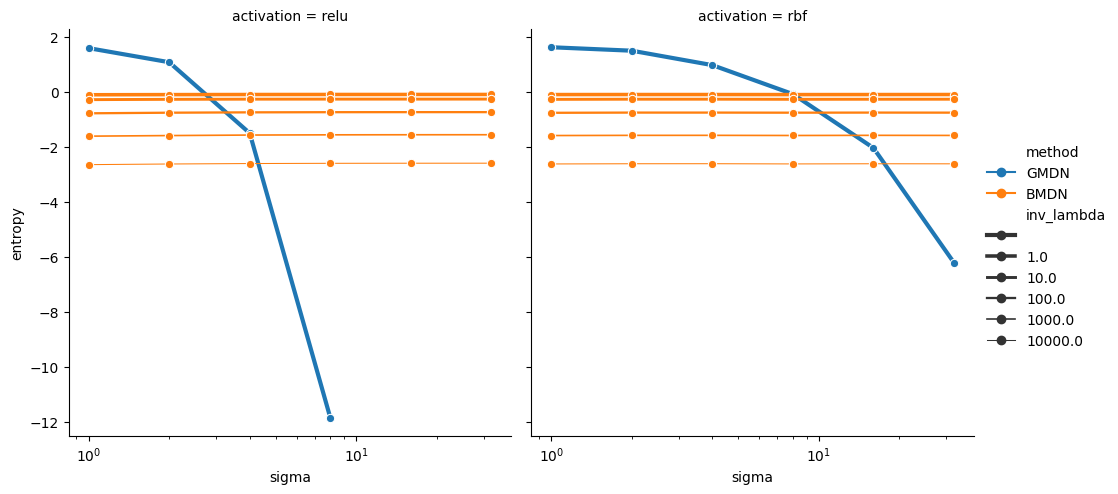

In [89]:
g_results = sns.relplot(
    data=df2, kind="line",
    x="sigma", y="entropy", 
    hue="method", col="activation",
    size="inv_lambda",
    facet_kws=dict(sharex=False), marker='o'
)
g_results.set(xscale='log')
g_results.savefig("entropy.pdf", bbox_inches='tight')
g_results

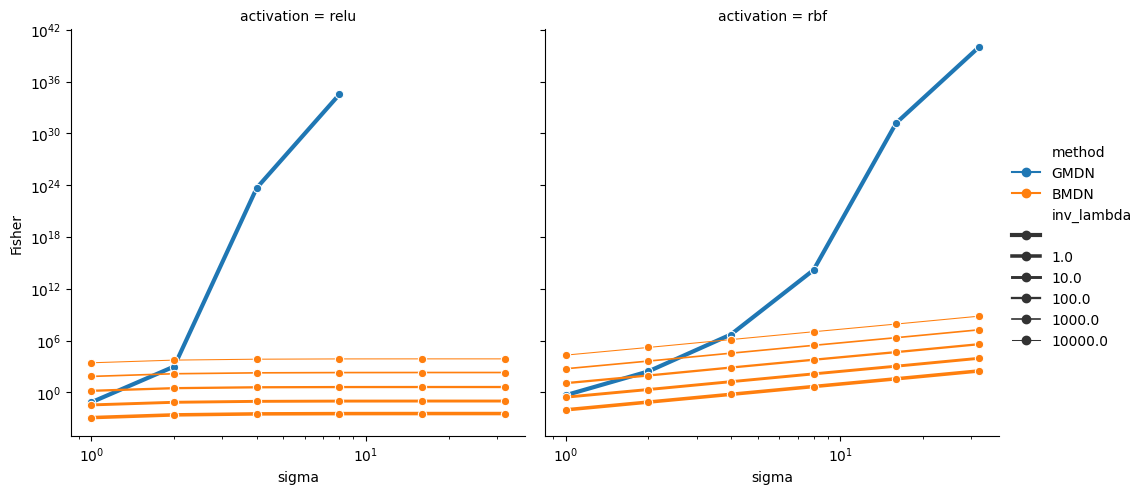

In [90]:
g_results = sns.relplot(
    data=df2, kind="line",
    x="sigma", y="Fisher", 
    hue="method", col="activation",
    size="inv_lambda",
    facet_kws=dict(sharex=False), marker='o'
)
g_results.set(xscale='log')
g_results.set(yscale='log')
g_results.savefig("fisher.pdf", bbox_inches='tight')
g_results

In [16]:
import scipy


scipy.stats.beta.entropy(100000,100000000)


-11.246782302856445